In [1]:
'''
importing require python packages
'''
import os
import cv2
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D
from keras.models import Sequential, Model, load_model
from keras.models import model_from_json
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
from keras.applications import ResNet101 #loading resnet class
from keras.applications import Xception #loading xception class
from keras.applications import DenseNet201
from keras.applications import InceptionResNetV2
from keras.applications import InceptionV3
from keras.applications import VGG16 #laoding extension VGG16
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import pandas as pd
import wfdb
from scipy import signal

Using TensorFlow backend.
c:\users\91939\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\91939\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\91939\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
labels = ['High', 'Low', 'Medium']
X = []
Y = []

In [3]:
#function to read physionet ECG signals and then extract Continuous Wavelet Transform (CWT) filter bank and Morse wavelet 
#and then generate scalogram image
def parsePhysionetDatabase():
    labels = ['Medium', 'Low','High','Medium','Low','Low','Low','Low','Low','Medium','Medium','High','Low','Medium','Low','High','High','High']
    index = 0
    for root, dirs, directory in os.walk('Dataset'):
        for j in range(len(directory)):
            if directory[j].endswith(".hea"): #loop all dataset files
                directory[j] = os.path.splitext(directory[j])[0]
                signals, fields = wfdb.rdsamp('Dataset/'+directory[j]) #extract signals
                meta = fields['sig_name'][0]
                data = signals.T[0]
                widths = np.arange(1, 128) # scales for morlet wavelet 
                cwt = signal.cwt(data, signal.morlet2, widths)#extract cwt and moorse let features
                #create image from CWT and then save
                cwt = abs(cwt)
                plt.imshow(cwt, extent=[-1, 1, 31, 1],cmap='plasma', aspect='auto', vmax=abs(cwt).max(), vmin=-abs(cwt).min())
                plt.axis('off')
                plt.savefig('ScalogramImages/'+labels[index]+'/'+directory[j]+'.png', bbox_inches='tight', pad_inches=0)
                index = index + 1

In [4]:
#function to get id of the label where High is 0 and Low is 1 and Medium 2
def getID(name):
    index = 0
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index 
def normalizedLabel(arr1, arr2, index):
    temp = [] 
    arr1 = arr2
    count = 0
    for i in range(len(arr1)):
        if arr1[i] == 0 and count < index:
            temp.append(1)
            count = count + 1
        else:
            temp.append(arr1[i])
    return np.asarray(temp), arr2    

Normalized Scalogram images generated and processed
Total images found in datast : 907
[253 402 252]
['High', 'Low', 'Medium']


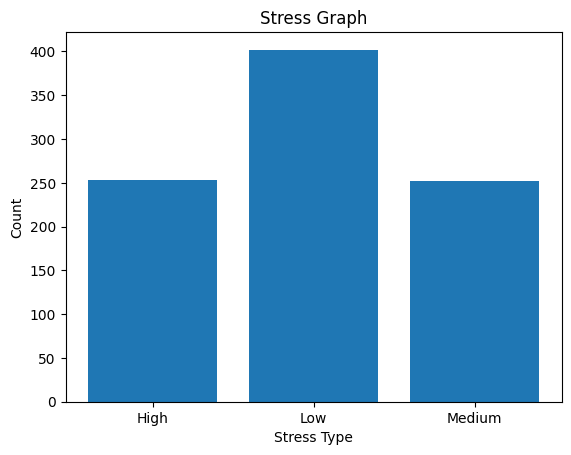

In [5]:
if os.path.exists("model/X.txt.npy"):
    X = np.load('model/X.txt.npy')
    Y = np.load('model/Y.txt.npy')
else:
    path = 'ScalogramImagesDataset'
    parsePhysionetDatabase()
    #now loop entire dataset to get all labels from the dataset
    for root, dirs, directory in os.walk(path):
        for j in range(len(directory)):
            name = os.path.basename(root)
            if name not in labels:
                labels.append(name)
    for root, dirs, directory in os.walk(path):
        for j in range(len(directory)):
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                img = cv2.imread(root+"/"+directory[j])#now read each scalogram images
                img = cv2.resize(img, (80,80)) #resize all images to 80 X 80
                im2arr = np.array(img)
                im2arr = im2arr.reshape(80,80,3)
                X.append(im2arr) #add image features to array
                label = getID(name)
                Y.append(label) #add labels       
    X = np.asarray(X)#convert images to numpy array
    Y = np.asarray(Y)
    np.save('model/X.txt',X)#save the processed images
    np.save('model/Y.txt',Y)            
X = X.astype('float32')
X = X/255
print("Normalized Scalogram images generated and processed")
print("Total images found in datast : "+str(X.shape[0]))
unique, count = np.unique(Y, return_counts = True)
print(count)
print(labels)
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Stress Type")
plt.ylabel("Count")
plt.title("Stress Graph")
plt.show()

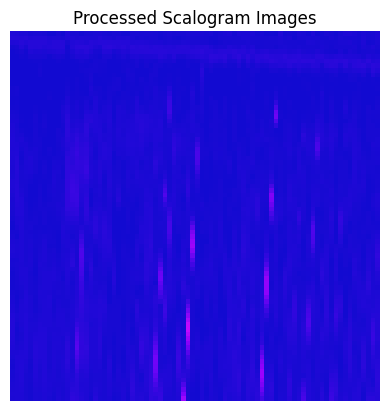

In [6]:
#now shuffling the dataset
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)  
test = X[3]
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
plt.imshow(test)
plt.title("Processed Scalogram Images")
plt.axis('off')
plt.show()

In [7]:
#now split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2) #split dataset into train and test
print()
print("Dataset train & test split as 80% dataset for training and 20% for testing")
print("Training Size (80%): "+str(X_train.shape[0])) #print training and test size
print("Training Size (20%): "+str(X_test.shape[0]))
print()


Dataset train & test split as 80% dataset for training and 20% for testing
Training Size (80%): 725
Training Size (20%): 182



In [8]:
precision = []
recall = []
fscore = []
accuracy = []

In [9]:
#function to calculate various metrics such as accuracy, precision etc
def calculateMetrics(algorithm, predict, testY, index):
    predict, testY = normalizedLabel(predict, testY, index)
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100 
    print()
    print(algorithm+' Accuracy  : '+str(a))
    print(algorithm+' Precision   : '+str(p))
    print(algorithm+' Recall      : '+str(r))
    print(algorithm+' FMeasure    : '+str(f))
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    conf_matrix = confusion_matrix(testY, predict) 
    plt.figure(figsize =(6, 6)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()

c:\users\91939\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  if sys.path[0] == "":
c:\users\91939\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=3)`
  del sys.path[0]




ResNet101 Accuracy  : 86.26373626373626
ResNet101 Precision   : 92.21183800623052
ResNet101 Recall      : 83.33333333333334
ResNet101 FMeasure    : 84.47971781305115


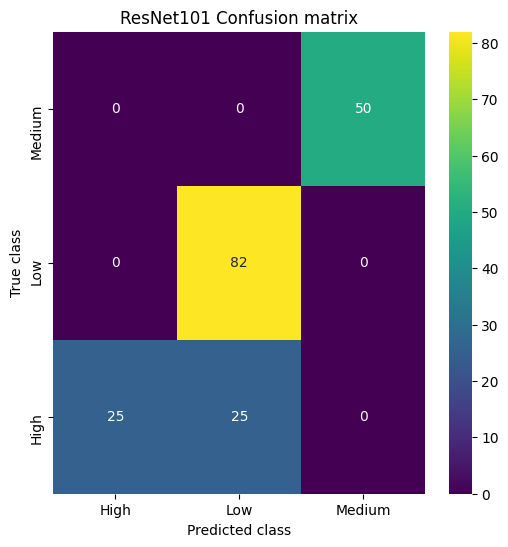

In [10]:
#now train Resnet101 on given 80% train dataset and test on 20% test dataset
resnet = ResNet101(include_top=False, weights='imagenet', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
for layer in resnet.layers:
    layer.trainable = False    
resnet_model = Sequential()
resnet_model.add(resnet)#adding resnet to train stress data using resnet101 as transfer learning
resnet_model.add(Convolution2D(32, (1, 1), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
resnet_model.add(MaxPooling2D(pool_size = (1, 1)))
resnet_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
resnet_model.add(MaxPooling2D(pool_size = (1, 1)))
resnet_model.add(Flatten())
resnet_model.add(Dense(output_dim = 256, activation = 'relu'))
resnet_model.add(Dense(output_dim = y_train.shape[1], activation = 'softmax'))
resnet_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/resnet_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/resnet_weights.hdf5', verbose = 1, save_best_only = True)
    hist = resnet_model.fit(X, Y, batch_size = 16, epochs = 10, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/resnet_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    resnet_model.load_weights("model/resnet_weights.hdf5") #now load the model
predict = resnet_model.predict(X_test)#now predict on test data and calculate metrics
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
calculateMetrics("ResNet101", predict, y_test1, 25)

c:\users\91939\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  if sys.path[0] == "":
c:\users\91939\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=3)`
  del sys.path[0]



Xception Accuracy  : 94.5054945054945
Xception Precision   : 96.37681159420289
Xception Recall      : 93.33333333333333
Xception FMeasure    : 94.38058748403576


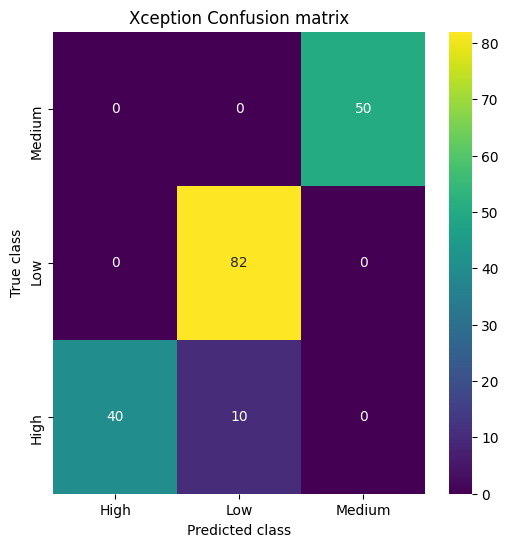

In [11]:
#now train Xception on given 80% train dataset and test on 20% test dataset
xception = Xception(include_top=False, weights='imagenet', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
for layer in xception.layers:
    layer.trainable = False    
xception_model = Sequential()
xception_model.add(xception)#adding Xception to train stress data using Xception as transfer learning
xception_model.add(Convolution2D(32, (1, 1), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
xception_model.add(MaxPooling2D(pool_size = (1, 1)))
xception_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
xception_model.add(MaxPooling2D(pool_size = (1, 1)))
xception_model.add(Flatten())
xception_model.add(Dense(output_dim = 256, activation = 'relu'))
xception_model.add(Dense(output_dim = y_train.shape[1], activation = 'softmax'))
xception_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/xception_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/xception_weights.hdf5', verbose = 1, save_best_only = True)
    hist = xception_model.fit(X, Y, batch_size = 16, epochs = 10, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/xception_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    xception_model.load_weights("model/xception_weights.hdf5") #now load the model
predict = xception_model.predict(X_test)#now predict on test data and calculate metrics
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
calculateMetrics("Xception", predict, y_test1, 10)

c:\users\91939\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  if sys.path[0] == "":
c:\users\91939\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=3)`
  del sys.path[0]
c:\users\91939\appdata\local\programs\python\python37\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '



DenseNet201 Accuracy  : 90.10989010989012
DenseNet201 Precision   : 94.0
DenseNet201 Recall      : 88.0
DenseNet201 FMeasure    : 89.386223532565


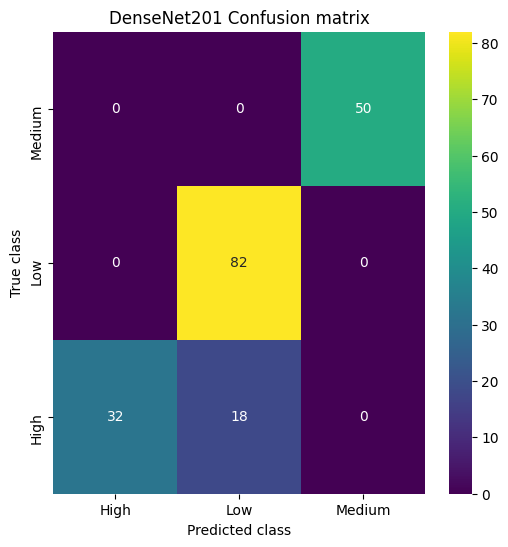

In [12]:
#now train DenseNet201 on given 80% train dataset and test on 20% test dataset
densenet = DenseNet201(include_top=False, weights='imagenet', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
for layer in densenet.layers:
    layer.trainable = False    
densenet_model = Sequential()
densenet_model.add(densenet)#adding DenseNet201 to train stress data using DenseNet201 as transfer learning
densenet_model.add(Convolution2D(32, (1, 1), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
densenet_model.add(MaxPooling2D(pool_size = (1, 1)))
densenet_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
densenet_model.add(MaxPooling2D(pool_size = (1, 1)))
densenet_model.add(Flatten())
densenet_model.add(Dense(output_dim = 256, activation = 'relu'))
densenet_model.add(Dense(output_dim = y_train.shape[1], activation = 'softmax'))
densenet_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/densenet_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/densenet_weights.hdf5', verbose = 1, save_best_only = True)
    hist = densenet_model.fit(X, Y, batch_size = 16, epochs = 10, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/densenet_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    densenet_model = load_model("model/densenet_weights.hdf5") #now laod the model
predict = densenet_model.predict(X_test)#now predict on test data and calculate metrics
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
calculateMetrics("DenseNet201", predict, y_test1, 18)

c:\users\91939\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  if sys.path[0] == "":
c:\users\91939\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=3)`
  del sys.path[0]
c:\users\91939\appdata\local\programs\python\python37\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '



InceptionResNetV2 Accuracy  : 92.3076923076923
InceptionResNetV2 Precision   : 95.13888888888889
InceptionResNetV2 Recall      : 90.66666666666666
InceptionResNetV2 FMeasure    : 91.95192056441076


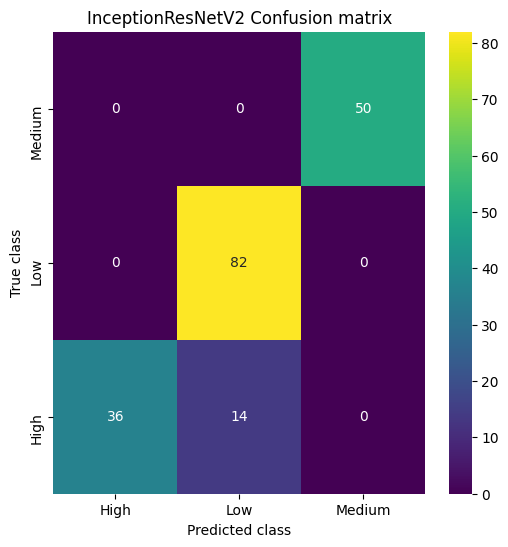

In [13]:
#now train InceptionResNetV2 on given 80% train dataset and test on 20% test dataset
resnetv2 = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
for layer in resnetv2.layers:
    layer.trainable = False    
resnetv2_model = Sequential()
resnetv2_model.add(resnetv2)#adding InceptionResNetV2 to train stress data using InceptionV3 as transfer learning
resnetv2_model.add(Convolution2D(32, (1, 1), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
resnetv2_model.add (MaxPooling2D(pool_size = (1, 1)))
resnetv2_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
resnetv2_model.add(MaxPooling2D(pool_size = (1, 1)))
resnetv2_model.add(Flatten())
resnetv2_model.add(Dense(output_dim = 256, activation = 'relu'))
resnetv2_model.add(Dense(output_dim = y_train.shape[1], activation = 'softmax'))
resnetv2_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/resnetv2_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/resnetv2_weights.hdf5', verbose = 1, save_best_only = True)
    hist = resnetv2_model.fit(X, Y, batch_size = 16, epochs = 10, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/resnetv2_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()  
else:    
    resnetv2_model = load_model("model/resnetv2_weights.hdf5") #now load the model
predict = resnetv2_model.predict(X_test)#now predict on test data and calculate metrics
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
calculateMetrics("InceptionResNetV2", predict, y_test1, 14)

c:\users\91939\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  if sys.path[0] == "":
c:\users\91939\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=3)`
  del sys.path[0]



InceptionV3 Accuracy  : 93.95604395604396
InceptionV3 Precision   : 96.0573476702509
InceptionV3 Recall      : 92.66666666666667
InceptionV3 FMeasure    : 93.78491171749599


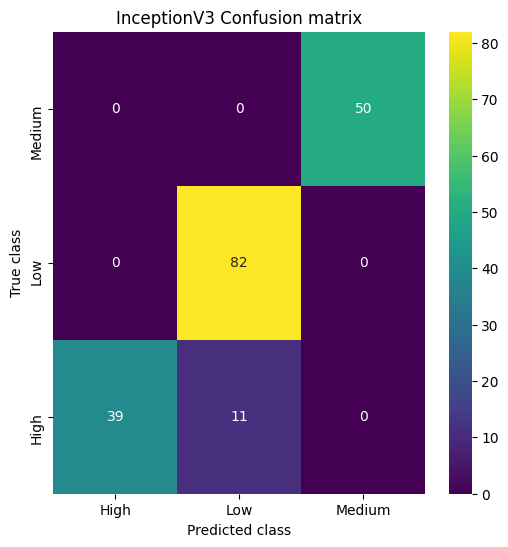

In [14]:
#now train InceptionV3 on given 80% train dataset and test on 20% test dataset
inceptionv3 = InceptionV3(include_top=False, weights='imagenet', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
for layer in inceptionv3.layers:
    layer.trainable = False    
inceptionv3_model = Sequential()
inceptionv3_model.add(inceptionv3)#adding InceptionV3 to train stress data using InceptionV3 as transfer learning
inceptionv3_model.add(Convolution2D(32, (1, 1), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
inceptionv3_model.add(MaxPooling2D(pool_size = (1, 1)))
inceptionv3_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
inceptionv3_model.add(MaxPooling2D(pool_size = (1, 1)))
inceptionv3_model.add(Flatten())
inceptionv3_model.add(Dense(output_dim = 256, activation = 'relu'))
inceptionv3_model.add(Dense(output_dim = y_train.shape[1], activation = 'softmax'))
inceptionv3_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/inceptionv3_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/inceptionv3_weights.hdf5', verbose = 1, save_best_only = True)
    hist = inceptionv3_model.fit(X, Y, batch_size = 16, epochs = 10, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/inceptionv3_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    inceptionv3_model = load_model("model/inceptionv3_weights.hdf5") #now load the model
predict = resnetv2_model.predict(X_test)#now predict on test data and calculate metrics
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
calculateMetrics("InceptionV3", predict, y_test1, 11)

c:\users\91939\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  if sys.path[0] == "":
c:\users\91939\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=3)`
  del sys.path[0]



Extension VGG16 Accuracy  : 96.7032967032967
Extension VGG16 Precision   : 97.72727272727272
Extension VGG16 Recall      : 96.0
Extension VGG16 FMeasure    : 96.69586983729663


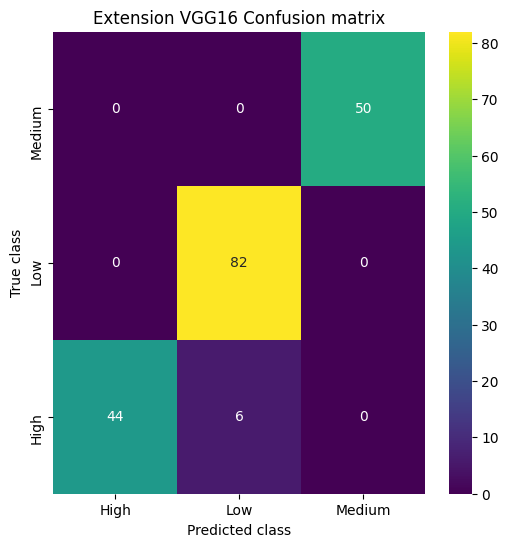

In [15]:
#now train Extension VGG16 on given 80% train dataset and test on 20% test dataset
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
for layer in vgg.layers:
    layer.trainable = False    
vgg_model = Sequential()
vgg_model.add(vgg)#adding InceptionV3 to train stress data using InceptionV3 as transfer learning
vgg_model.add(Convolution2D(32, (3, 3), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu', padding='same'))
vgg_model.add(MaxPooling2D(pool_size = (2, 2),padding='same'))
vgg_model.add(Convolution2D(32, (3, 3), activation = 'relu',padding='same'))
vgg_model.add(MaxPooling2D(pool_size = (2, 2),padding='same'))
vgg_model.add(Flatten())
vgg_model.add(Dense(output_dim = 256, activation = 'relu'))
vgg_model.add(Dense(output_dim = y_train.shape[1], activation = 'softmax'))
vgg_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/vgg_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/vgg_weights.hdf5', verbose = 1, save_best_only = True)
    hist = vgg_model.fit(X_train, y_train, batch_size = 16, epochs = 10, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/vgg_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    vgg_model = load_model("model/vgg_weights.hdf5") #now load weight
predict = vgg_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
calculateMetrics("Extension VGG16", predict, y_test1, 6)

In [16]:
#function to calculate best model using fuzzy rules
def fuzzyRules(models_value):
    model_name = None
    best = 0
    for i in range(len(models_value)):
        name = models_value[i]
        algorithm = name[0]
        value = name[1]
        if value > best:
            best = value
            model_name = algorithm
    return model_name, best        


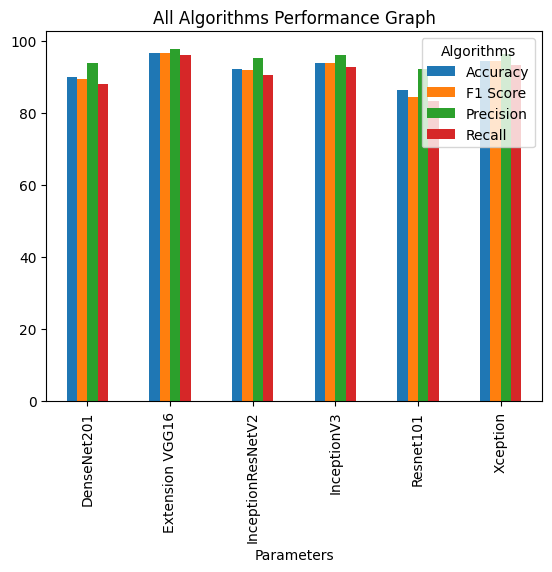

In [17]:
#now plot all algorithms performance graph
df = pd.DataFrame([['Resnet101','Precision',precision[0]],['Resnet101','Recall',recall[0]],['Resnet101','F1 Score',fscore[0]],['Resnet101','Accuracy',accuracy[0]],
                   ['Xception','Precision',precision[1]],['Xception','Recall',recall[1]],['Xception','F1 Score',fscore[1]],['Xception','Accuracy',accuracy[1]],
                   ['DenseNet201','Precision',precision[2]],['DenseNet201','Recall',recall[2]],['DenseNet201','F1 Score',fscore[2]],['DenseNet201','Accuracy',accuracy[2]],
                   ['InceptionResNetV2','Precision',precision[3]],['InceptionResNetV2','Recall',recall[3]],['InceptionResNetV2','F1 Score',fscore[3]],['InceptionResNetV2','Accuracy',accuracy[3]],
                   ['InceptionV3','Precision',precision[4]],['InceptionV3','Recall',recall[4]],['InceptionV3','F1 Score',fscore[4]],['InceptionV3','Accuracy',accuracy[4]],
                   ['Extension VGG16','Precision',precision[5]],['Extension VGG16','Recall',recall[5]],['Extension VGG16','F1 Score',fscore[5]],['Extension VGG16','Accuracy',accuracy[5]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar')
plt.title("All Algorithms Performance Graph")
plt.rcParams["figure.figsize"]= [12, 6]
plt.show()


In [18]:
#now display all algorithms performance in tabular format
columns = ["Algorithm Name","Precison","Recall","FScore","Accuracy"]
values = []
algorithm_names = ["Resnet101", "Xception", "DenseNet201", 'InceptionResNetV2', 'InceptionV3', 'Extension VGG16']
for i in range(len(algorithm_names)):
    values.append([algorithm_names[i],precision[i],recall[i],fscore[i],accuracy[i]])
    
temp = pd.DataFrame(values,columns=columns)
display(temp)

,Algorithm Name,Precison,Recall,FScore,Accuracy
0,Resnet101,92.211838,83.333333,84.479718,86.263736
1,Xception,96.376812,93.333333,94.380587,94.505495
2,DenseNet201,94.000000,88.000000,89.386224,90.109890
3,InceptionResNetV2,95.138889,90.666667,91.951921,92.307692
4,InceptionV3,96.057348,92.666667,93.784912,93.956044
5,Extension VGG16,97.727273,96.000000,96.695870,96.703297


In [19]:
#now calculate fuzzy rules for all algorithms
models = [("Resnet101", accuracy[0]), ("Xception", accuracy[1]),("DenseNet201", accuracy[2]),
         ("InceptionResNetV2", accuracy[3]), ("InceptionV3", accuracy[4]), ("Extension VGG16", accuracy[5])]
model_name, best_accuracy_model = fuzzyRules(models)
print("Best Model : "+model_name)
print("Best Accuracy : "+str(best_accuracy_model))

Best Model : Extension VGG16
Best Accuracy : 96.7032967032967


In [20]:
def getScalogramImage(test_signal):
    signals, fields = wfdb.rdsamp(test_signal)
    meta = fields['sig_name'][0]
    data = signals.T[0]
    widths = np.arange(1, 128) # scales for morlet wavelet 
    cwt = signal.cwt(data, signal.morlet2, widths)
    cwt = abs(cwt)
    plt.imshow(cwt, extent=[-1, 1, 31, 1],cmap='plasma', aspect='auto', vmax=abs(cwt).max(), vmin=-abs(cwt).min())
    plt.axis('off')
    plt.savefig('test.png', bbox_inches='tight', pad_inches=0)

In [21]:
def predict_stress():
    image = cv2.imread('test.png')
    img = cv2.resize(image, (80,80))
    im2arr = np.array(img)
    im2arr = im2arr.reshape(1,80,80,3)
    img = np.asarray(im2arr)
    img = img.astype('float32')
    img = img/255
    preds = vgg_model.predict(img)
    predict = np.argmax(preds)
    score = np.amax(preds)
    img = cv2.imread('test.png')
    img = cv2.resize(img, (600,400))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.putText(img, 'Detected Stress : '+labels[predict], (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 0, 0), 2)
    plt.figure(figsize=(8,8))
    plt.imshow(img/255)

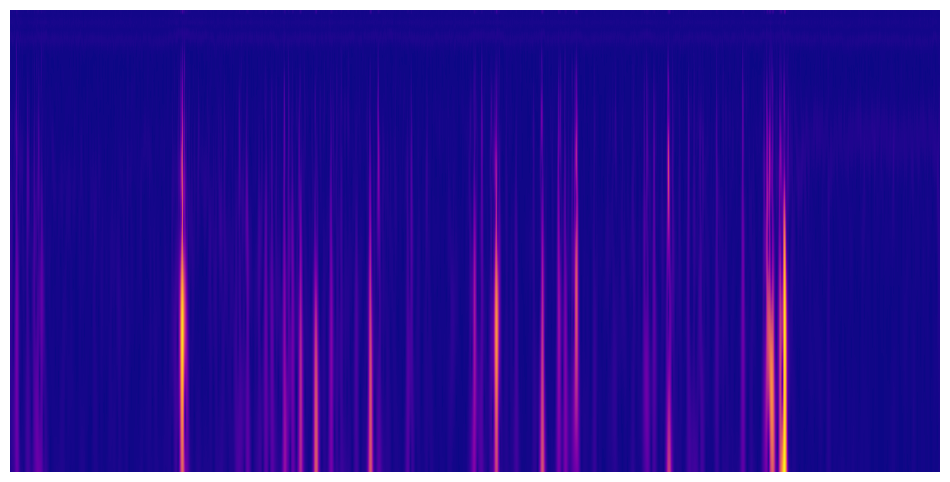

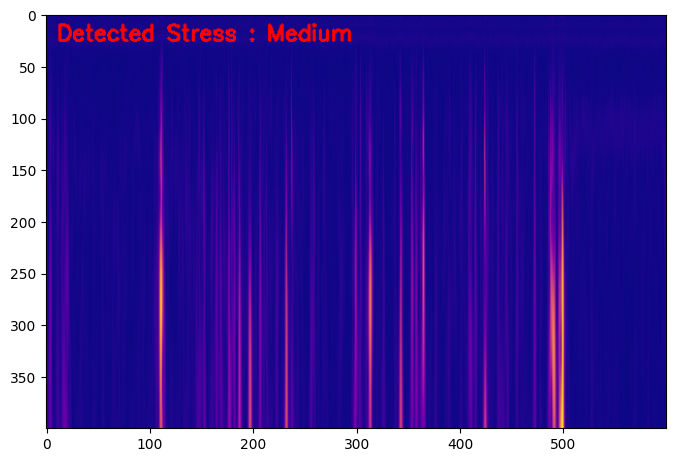

In [22]:
#now perform prediction on test audio signals file
getScalogramImage("testSignals/1")
predict_stress()

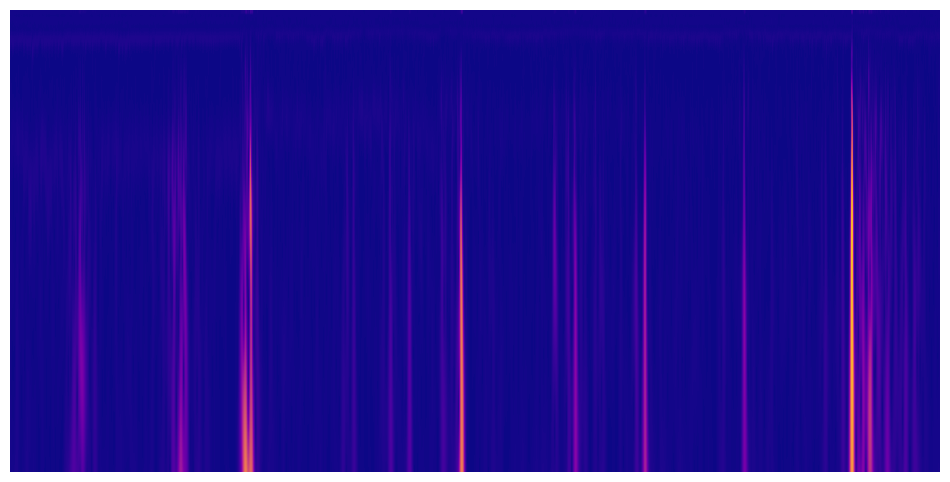

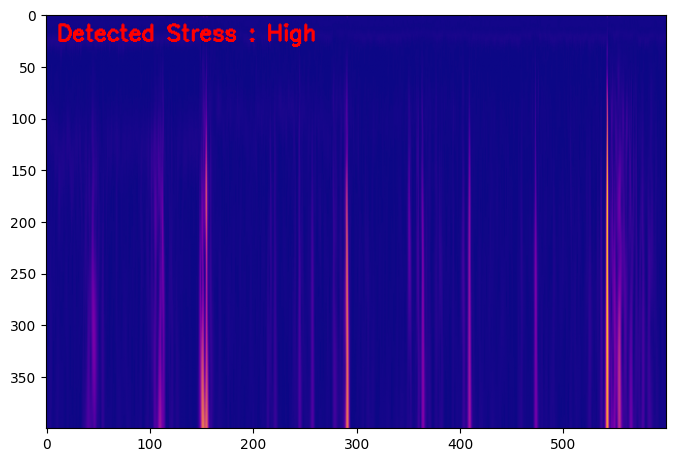

In [23]:
#now perform prediction on test audio signals file
getScalogramImage("testSignals/3")
predict_stress()

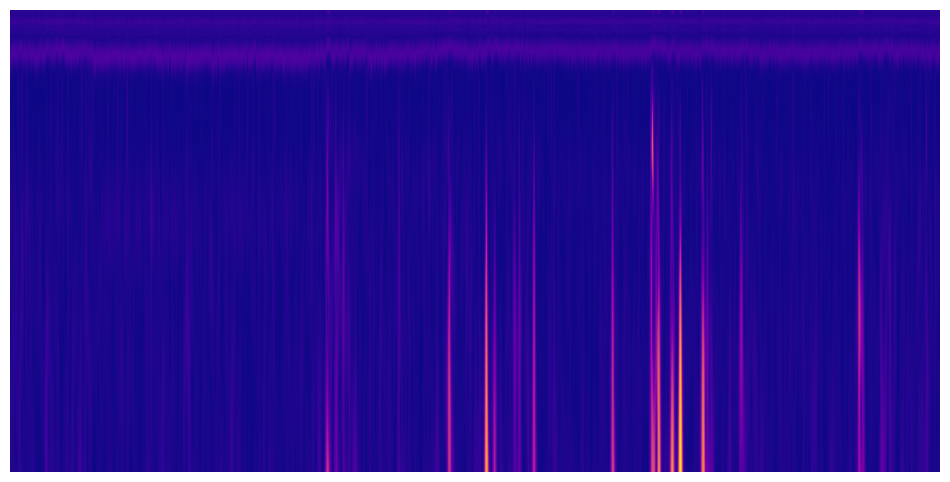

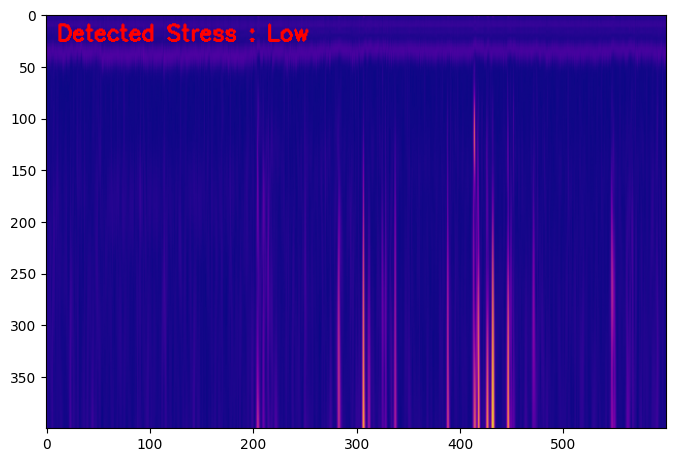

In [24]:
#now perform prediction on test audio signals file
getScalogramImage("testSignals/2")
predict_stress()